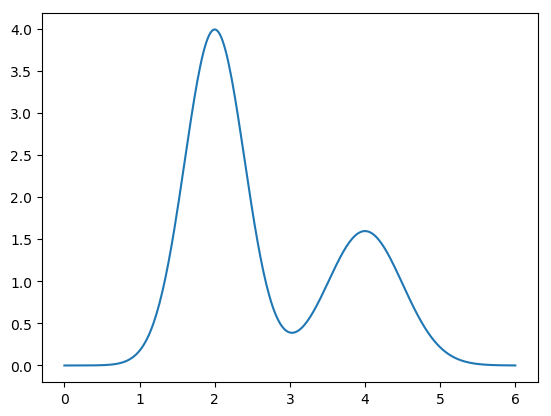

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19583d208>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "triangular"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

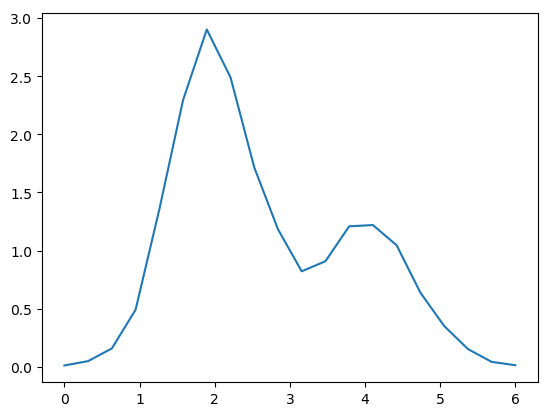

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x199284320>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

1.0
10.0
45.0
120.0
210.0
252.0
210.0
120.0
45.0
10.0
1.0
9

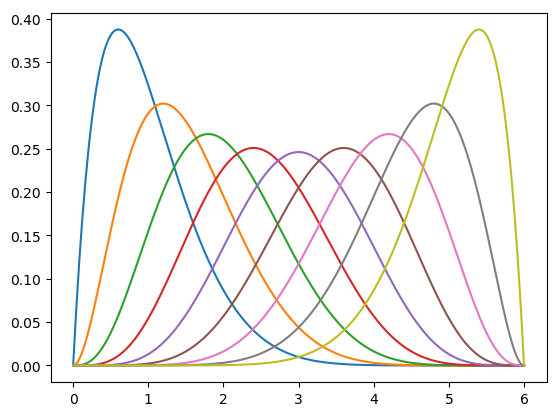

In [4]:
basis = BernsteinBasis(a, b, 10,  ("dirichlet", "dirichlet"))
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
println(length(basis))

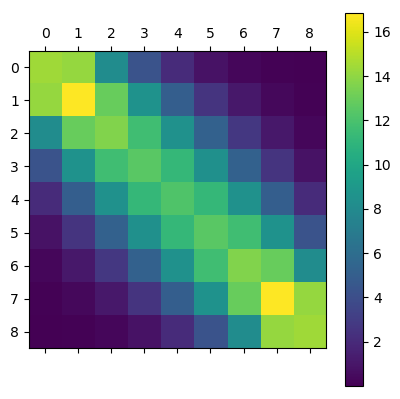

9

PyObject <matplotlib.colorbar.Colorbar object at 0x11d9425f8>

In [5]:
print(length(basis))
my_omega = omega(basis, 2)[1]
# for i = 1:size(my_omega)[1]
#     for j = 1:size(my_omega)[1]
#         my_omega[i, j] = abs(my_omega[i, j])
#     end
# end
matshow(my_omega)
colorbar()

In [6]:
model = GaussErrorUnfolder(basis, omega(basis, 2))

GaussErrorUnfolder(BernsteinBasis(0.0, 6.0, Any[BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 1, 10.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 2, 45.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 3, 120.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 4, 210.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 5, 252.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 6, 210.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 7, 120.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 8, 45.0), (0.0, 6.0)), BaseFunction(##54#56{Float64,Float64,Int64,Int64,Float64}(0.0, 6.0, 10, 9, 10.0), (0.0, 6.0))], ("dirichlet", "dirichlet")), GaussErrorMatrixUnfolder(Array{Float64,2}[[14.4118 14.1912 … 0

starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -5.603933e+01     4.629258e+01
     1    -1.900621e+02     8.999526e+00
     2    -2.719246e+02     5.653231e+00
     3    -2.750678e+02     3.148507e+00
     4    -2.759625e+02     4.873532e-01
     5    -2.759798e+02     3.027469e-03
     6    -2.759798e+02     5.729430e-05
     7    -2.759798e+02     2.709225e-05
     8    -2.759798e+02     8.862472e-06
     9    -2.759798e+02     6.935174e-06
    10    -2.759798e+02     1.702833e-07
    11    -2.759798e+02     5.780344e-05
    12    -2.759798e+02     2.479171e-04
    13    -2.759798e+02     1.948623e-05
    14    -2.759798e+02     1.241036e-04
    15    -2.759798e+02     3.957794e-05
    16    -2.759798e+02     9.747410e-06
    17    -2.759798e+02     2.466523e-05
    18    -2.759798e+02     8.295098e-05
    19    -2.759798e+02     3.927272e-05
    20    -2.759798

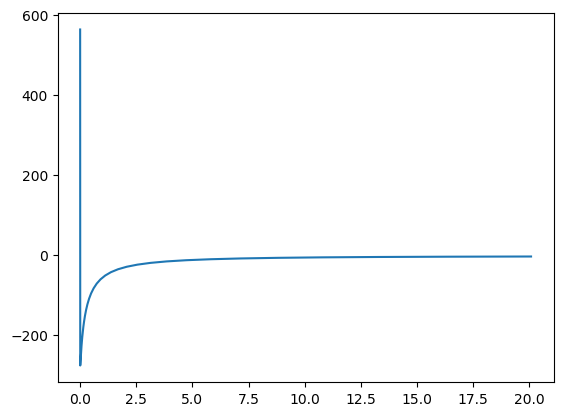

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.004264]
  "coeff"  => [1.59414, -0.370573, -36.9725, 142.061, -198.015, 149.47, -58.392…
  "sig"    => [14.9561 -76.1659 … -19.8444 2.35218; -76.1659 418.557 … 157.636 …

In [7]:
phi_reconstruct = solve(model, kernel, f, sig, y)

In [8]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["sig"])
println()

[0.0, 0.0513923, 0.0984643, 0.140626, 0.177433, 0.208578, 0.233869, 0.253225, 0.266661, 0.274276, 0.276246, 0.27281, 0.264266, 0.250959, 0.233273, 0.211628, 0.186468, 0.158259, 0.12748, 0.0946193, 0.0601712, 0.0246283, -0.0115203, -0.0477932, -0.08372, -0.118844, -0.152726, -0.184944, -0.215098, -0.24281, -0.267727, -0.289521, -0.307889, -0.322557, -0.333277, -0.33983, -0.342026, -0.339703, -0.332726, -0.320989, -0.304415, -0.282953, -0.256578, -0.225292, -0.189122, -0.14812, -0.102359, -0.0519386, 0.0030243, 0.0623905, 0.126002, 0.193683, 0.265241, 0.340468, 0.419142, 0.501027, 0.585876, 0.673432, 0.763428, 0.85559, 0.949637, 1.04528, 1.14224, 1.2402, 1.33889, 1.43799, 1.53723, 1.63629, 1.7349, 1.83276, 1.92958, 2.0251, 2.11903, 2.21112, 2.30111, 2.38874, 2.47379, 2.55601, 2.6352, 2.71114, 2.78365, 2.85254, 2.91763, 2.97877, 3.03582, 3.08865, 3.13714, 3.18118, 3.22069, 3.2556, 3.28584, 3.31136, 3.33214, 3.34815, 3.3594, 3.36589, 3.36764, 3.36469, 3.3571, 3.34491, 3.32822, 3.30709, 3.2

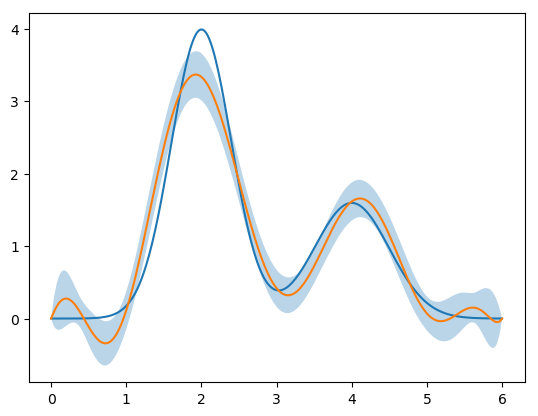

{Float64,1}Array{Float64,1}300300

PyObject <matplotlib.collections.PolyCollection object at 0x19a00f438>

In [9]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, phi_reconstructed)
print(phi_reconstructed)
print(typeof(x), typeof(phi_reconstructed))
print(length(x), length(phi_reconstructed))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

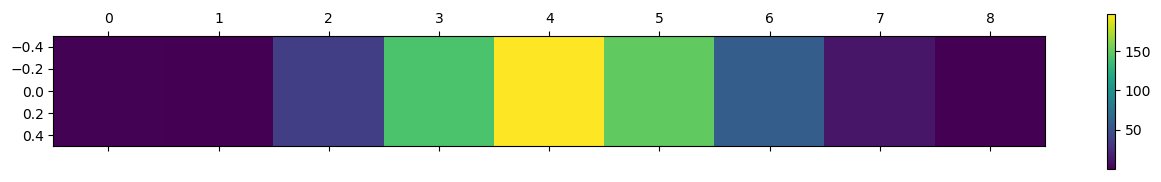

PyObject <matplotlib.colorbar.Colorbar object at 0x199972e48>

In [10]:
matshow(reshape(map(x->abs(x), phi_reconstruct["coeff"]), (1, length(basis))))
colorbar()

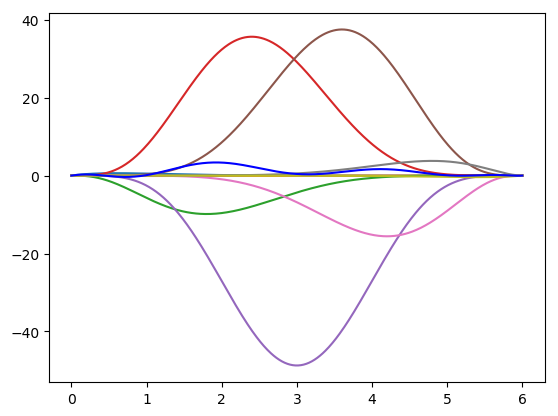

[1.59414, -0.370573, -36.9725, 142.061, -198.015, 149.47, -58.3924, 12.4735, -1.03271]

In [11]:
basis_functions = basis.basis_functions
z = collect(range(a, b, length=500))
my_sum = zeros(length(z))
for i = 1:length(basis_functions)
    basis_function = basis_functions[i]
    coeff = phi_reconstruct["coeff"][i]
    plot(z, coeff * basis_function.f.(z))
    my_sum += coeff * basis_function.f.(z)
#     plot(z, basis_function.f.(z))
end
# plot(z, phi.(z), "r")
plot(z, my_sum, "b")
print(phi_reconstruct["coeff"])

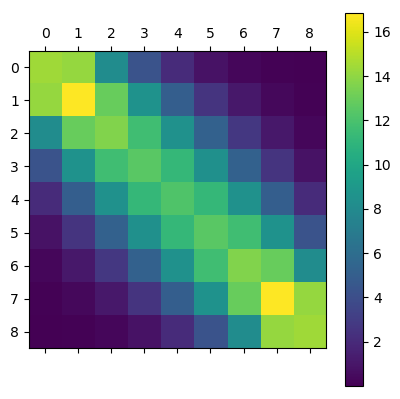

1.7294117462842725e-6

In [12]:
my_omega = omega(basis, 2)[1]
# for i = 1:size(phi_reconstruct["sig"])[1]
#     for j = 1:size(phi_reconstruct["sig"])[1]
#         if i == j
#             println(phi_reconstruct["sig"][i, j])
#         end
#         phi_reconstruct["sig"][i, j] = abs(phi_reconstruct["sig"][i, j])
#     end
# end
# matshow(phi_reconstruct["sig"])
matshow(my_omega)
colorbar()
det(my_omega)